In [65]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from utils import *
import tensorflow as tf

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Train
training_set = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    validation_split = 0.2,
    subset="training",
    shuffle=True,
    seed=19032024,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
)
# Test
validate_set = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    validation_split = 0.2,
    subset="validation",
    shuffle=True,
    seed=19032024,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
)


Found 480 files belonging to 4 classes.
Using 384 files for training.
Found 480 files belonging to 4 classes.
Using 96 files for validation.


In [66]:
class_names = training_set.class_names
print(class_names)
class_names = validate_set.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']
['glioma', 'meningioma', 'notumor', 'pituitary']


2024-06-03 15:40:55.227006: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-03 15:40:55.264910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-03 15:40:55.336673: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.

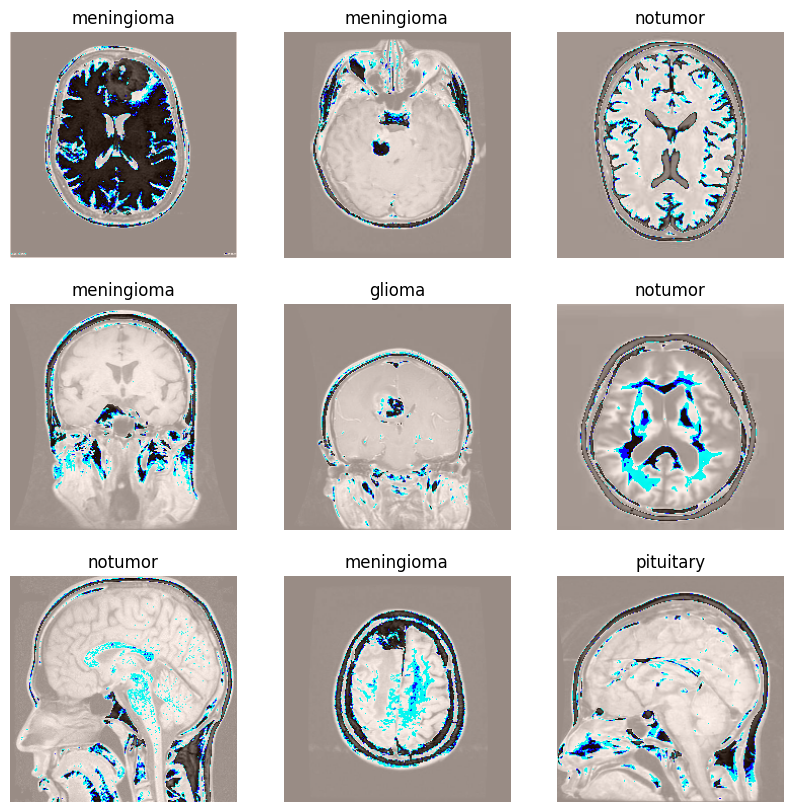

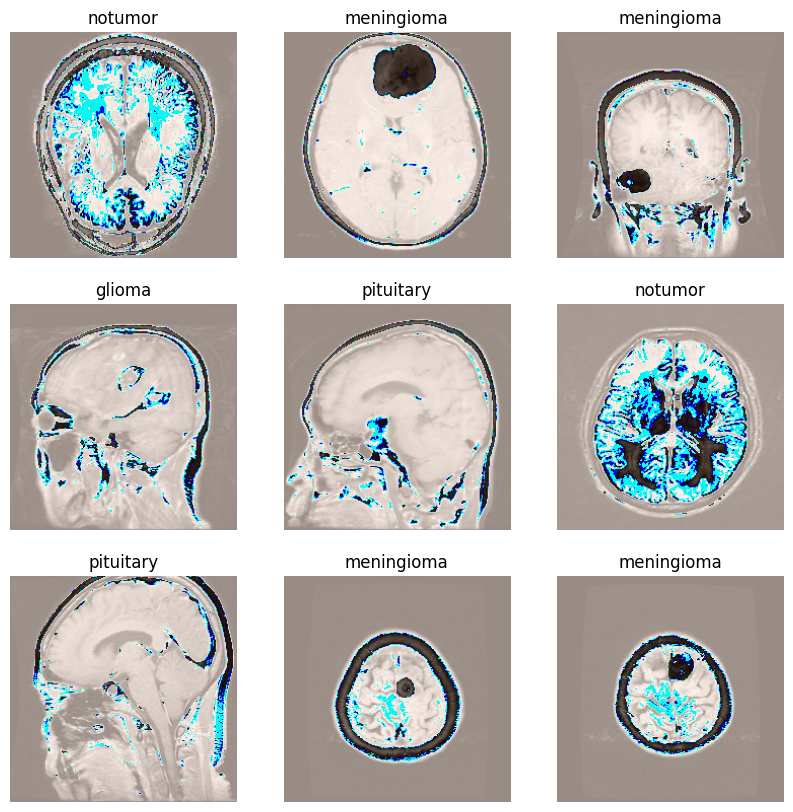

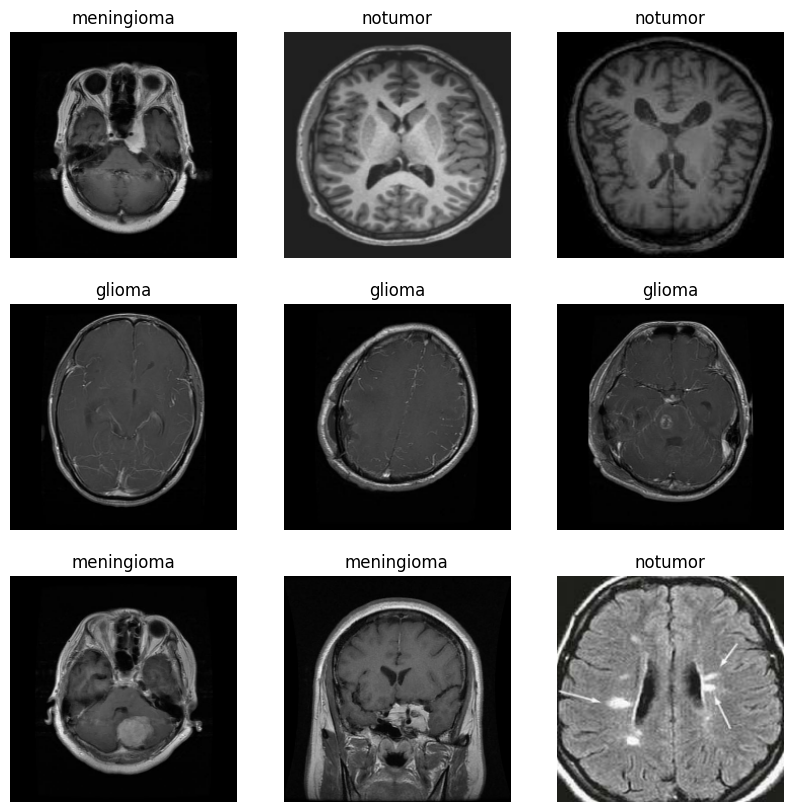

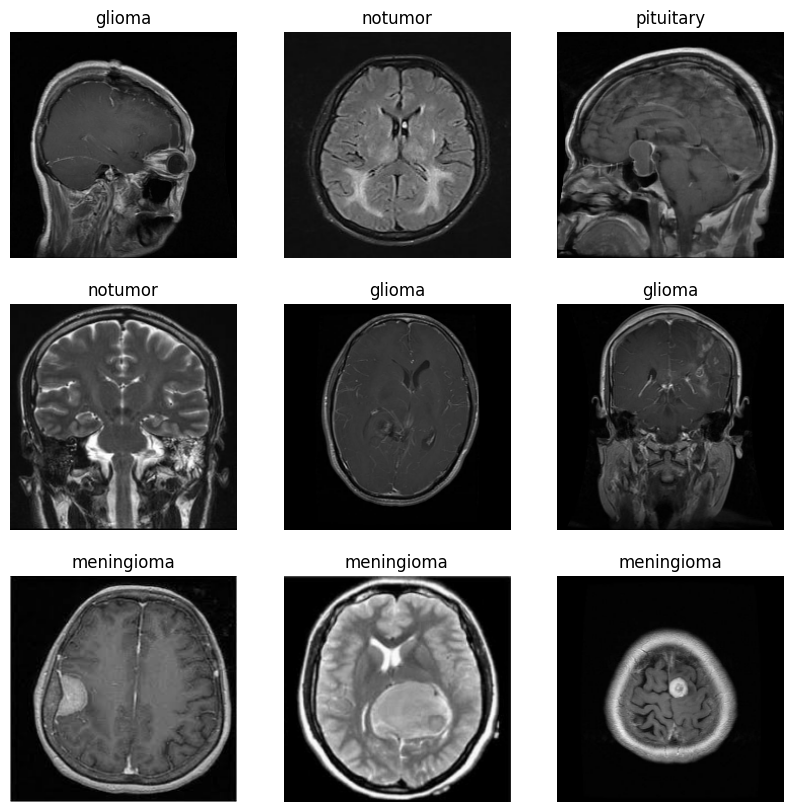

In [67]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

train_ds = preprocess(training_set).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = preprocess(validate_set).cache().prefetch(buffer_size=AUTOTUNE)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in validate_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [68]:
# Load the ResNet50 model with pre-trained weights
resnet_model = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet', include_top=False)

# Freeze the base model
resnet_model.trainable = False

# Add custom layers on top of the base model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
x = global_average_layer(resnet_model.output)
x = Dense(1024, activation='relu')(x) 
prediction = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=resnet_model.input, outputs=prediction)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_21[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [69]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3964 - loss: 3.4837 - val_accuracy: 0.6562 - val_loss: 1.2088
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7770 - loss: 0.6184 - val_accuracy: 0.8646 - val_loss: 0.3363
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9065 - loss: 0.2693 - val_accuracy: 0.7812 - val_loss: 0.4684
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9146 - loss: 0.2294 - val_accuracy: 0.8854 - val_loss: 0.2810
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9571 - loss: 0.1133 - val_accuracy: 0.8438 - val_loss: 0.3631
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9726 - loss: 0.0944 - val_accuracy: 0.8958 - val_loss: 0.2855
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9876 - loss: 0.0651 - val_accuracy: 0.9062 - val_loss: 0.2625
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9913 - loss: 0.0517 - val_accuracy: 0.8542 - v

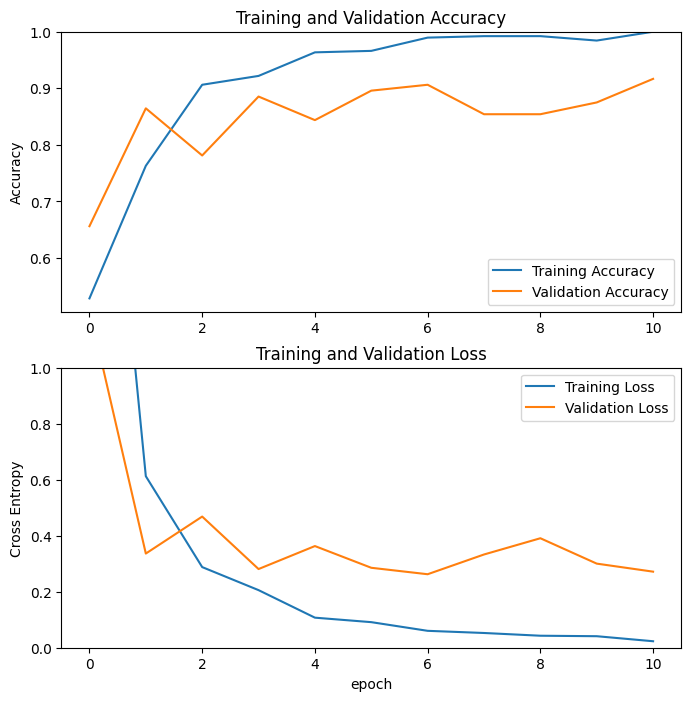

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 833ms/step - accuracy: 0.9141 - loss: 0.2519
Test Accuracy : 0.90625
Test Loss : 0.26245996356010437
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 827ms/step - accuracy: 0.9141 - loss: 0.2519
Validation Accuracy: 0.91


In [70]:
""" Preliminary Model Performance """
# View training metrics across epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(val_ds)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)


# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.2f}')


In [71]:
model.save(MODEL_FILE)

In [72]:
""" Model Performance """
# Load images and labels
images, labels, class_names = load_data(DATASET_FOLDER)

# Load the trained model
model = keras.models.load_model(MODEL_FILE)

# Train-Test split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=1234)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [73]:
# Initialise predictions
list_train_pred = []
list_test_pred = []
for image_path in x_train:
    list_train_pred.append(predict_class(image_path, model, class_names, (224, 224), verbose_output=1))
for image_path in x_test:
    list_test_pred.append(predict_class(image_path, model, class_names, (224, 224), verbose_output=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━

In [74]:
# Get model's training performance
training_results = classifier_metrics(list(y_train), list_train_pred, print_results=True)

Accuracy: 0.9713541666666666
Precision: 0.9715113438992619
Recall: 0.9713541666666666
F1 Score: 0.9713798833423766
Matthews Correlation Coefficient (MCC): 0.9618403449703412
Cohen's Kappa: 0.9618055555555556
Hamming Loss: 0.028645833333333332

Confusion Matrix:
 [[93  2  0  1]
 [ 1 91  1  3]
 [ 0  1 95  0]
 [ 0  2  0 94]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.97      0.98        96
  meningioma       0.95      0.95      0.95        96
     notumor       0.99      0.99      0.99        96
   pituitary       0.96      0.98      0.97        96

    accuracy                           0.97       384
   macro avg       0.97      0.97      0.97       384
weighted avg       0.97      0.97      0.97       384





In [75]:
# Get model's test performance
test_results = classifier_metrics(list(y_test), list_test_pred, print_results=True)

Accuracy: 0.9895833333333334
Precision: 0.99
Recall: 0.9895833333333334
F1 Score: 0.9895788102475032
Matthews Correlation Coefficient (MCC): 0.9862538086172644
Cohen's Kappa: 0.9861111111111112
Hamming Loss: 0.010416666666666666

Confusion Matrix:
 [[24  0  0  0]
 [ 0 23  0  1]
 [ 0  0 24  0]
 [ 0  0  0 24]]

Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      1.00      1.00        24
  meningioma       1.00      0.96      0.98        24
     notumor       1.00      1.00      1.00        24
   pituitary       0.96      1.00      0.98        24

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96



